In [20]:
import json
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

In [22]:
# def get_feature_set(json_data):
#     feature_set = set()
#     for occupation, info in json_data.items():
#         for feature in info['attribute']:
#             # print(feature)
#             feature_set.add(feature)
#     return feature_set

# data = load_data('output/occupation_attribute_100.json')
# feature_set = get_feature_set(data)

def get_feature_set(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    feature_set = set(data.keys())
    return feature_set

file_path = 'output/freq_words/frequent_word_1000.json'
feature_set = get_feature_set(file_path)


In [23]:
len(feature_set)

1000

# from wikipedia

In [ ]:
from utils import build_probability_matrix_from_list, save_outputs, save_sorted_probabilities

In [25]:
# json_file = 'output/occupation_data_100.json'
json_file = 'output/occupation_summaries_200.json'
data = load_data(json_file)
wiki_summary_list = [i for i in data.values()]
feature_list, prob_matrix, feature_counts, co_occurrence_counts = build_probability_matrix_from_list(wiki_summary_list, feature_set)

Processing occupations: 100%|██████████| 105840/105840 [02:37<00:00, 672.91it/s]


In [ ]:
save_outputs(feature_list, prob_matrix, feature_counts, co_occurrence_counts, 'output/wiki_vs_gen/new_features/wiki')

In [28]:
output_prefix = 'output/wiki_vs_gen_report/new_features/wiki'
output_file = output_prefix + '_sorted_probabilities_report.txt'
save_sorted_probabilities(feature_list, prob_matrix, feature_counts, co_occurrence_counts, output_file)

# from generation

In [29]:
import json
from pathlib import Path

def load_data_from_jsonl(jsonl_files):
    data = []
    for file_path in jsonl_files:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Each line is a complete JSON object
                entry = json.loads(line)
                data.append(entry)
    return data

unlabeled_path = Path('data/unlabeled')
labeled_path = Path('data/labeled')
jsonl_files = list(unlabeled_path.glob('*.jsonl'))+list(labeled_path.glob('*.jsonl'))######
all_data = load_data_from_jsonl(jsonl_files)
gen_output_list = [i['output'] for i in all_data]


In [30]:
jsonl_files

[PosixPath('data/unlabeled/Alpaca-13B.jsonl'),
 PosixPath('data/unlabeled/Alpaca-65B.jsonl'),
 PosixPath('data/unlabeled/Alpaca-7B.jsonl'),
 PosixPath('data/unlabeled/ChatGPT.jsonl'),
 PosixPath('data/unlabeled/Dolly-12B.jsonl'),
 PosixPath('data/unlabeled/Pythia-12B.jsonl'),
 PosixPath('data/unlabeled/GPT-4.jsonl'),
 PosixPath('data/unlabeled/InstructGPT.jsonl'),
 PosixPath('data/unlabeled/MPT-Chat-7B.jsonl'),
 PosixPath('data/unlabeled/Stablelm-alpha-7B.jsonl'),
 PosixPath('data/unlabeled/Vicuna-13B.jsonl'),
 PosixPath('data/unlabeled/Vicuna-7B.jsonl'),
 PosixPath('data/labeled/ChatGPT.jsonl'),
 PosixPath('data/labeled/InstructGPT.jsonl'),
 PosixPath('data/labeled/PerplexityAI.jsonl')]

In [31]:
feature_list_gen, prob_matrix_gen, feature_counts_gen, co_occurrence_counts_gen = build_probability_matrix_from_list(gen_output_list, feature_set)

Processing occupations: 100%|██████████| 6549/6549 [00:11<00:00, 568.44it/s] 


In [32]:
save_outputs(feature_list_gen, prob_matrix_gen, feature_counts_gen, co_occurrence_counts_gen, 'output/wiki_vs_gen/new_features/gen')

In [33]:
output_prefix = 'output/wiki_vs_gen_report/new_features/gen'
output_file = output_prefix + '_sorted_probabilities_report.txt'
save_sorted_probabilities(feature_list_gen, prob_matrix_gen, feature_counts_gen, co_occurrence_counts_gen, output_file)

# compare

In [34]:
def compare_probability_matrices(wiki_matrix, gen_matrix, feature_list, output_file):

    matrix_size = len(feature_list)
    differences = np.zeros((matrix_size, matrix_size))
    
    for i in range(matrix_size):
        for j in range(matrix_size):
            differences[i][j] = gen_matrix[i][j] - wiki_matrix[i][j]

    # print(differences)

    flat_differences = []
    for i in range(matrix_size):
        for j in range(matrix_size):
            flat_differences.append(((feature_list[i], feature_list[j]), differences[i][j]))

    flat_differences.sort(key=lambda x: x[1], reverse=True)
    
    significant_differences = {
        'most_positive': flat_differences[:20], 
        'most_negative': flat_differences[-20:] 
    }

    with open(output_file, 'w') as f:
        json.dump(significant_differences, f, indent=4)

    return significant_differences

In [37]:
print(len(prob_matrix))
print(len(feature_list))
print(len(prob_matrix_gen))

1000
1000
1000


In [36]:

wiki_prob_matrix = prob_matrix
gen_prob_matrix = prob_matrix_gen
feature_list = feature_list

output_file_path = 'comparison_results_allow_same.json'
comparison_results = compare_probability_matrices(wiki_prob_matrix, gen_prob_matrix, feature_list, output_file_path)


# build buckets and compare

In [ ]:
import pandas as pd

def flatten_matrix(matrix, feature_list):
    flattened_data = []
    for i in range(len(feature_list)):
        for j in range(len(feature_list)):
            value = matrix[i, j]
            flattened_data.append((feature_list[i], feature_list[j], value))
    return flattened_data

wiki_flattened = flatten_matrix(prob_matrix, feature_list)
gen_flattened = flatten_matrix(prob_matrix_gen, feature_list_gen)

wiki_df = pd.DataFrame(wiki_flattened, columns=['Feature1', 'Feature2', 'Wiki_Prob'])
gen_df = pd.DataFrame(gen_flattened, columns=['Feature1', 'Feature2', 'Gen_Prob'])

comparison_df = pd.merge(wiki_df, gen_df, on=['Feature1', 'Feature2'], how='inner')
comparison_df = comparison_df[comparison_df['Wiki_Prob'] != 0]
comparison_df = comparison_df[comparison_df['Gen_Prob'] != 0]

comparison_df['Wiki_Bucket'] = pd.qcut(comparison_df['Wiki_Prob'], 5, labels=False) + 1
comparison_df['Gen_Bucket'] = pd.qcut(comparison_df['Gen_Prob'], 5, labels=False) + 1

comparison_df['Change'] = comparison_df['Gen_Prob'] - comparison_df['Wiki_Prob']
comparison_df['Change_Direction'] = comparison_df['Change'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change'))

In [69]:
comparison_df = comparison_df.sort_values(by='Wiki_Prob', ascending=False)
comparison_df.head()

,Feature1,Feature2,Wiki_Prob,Gen_Prob,Wiki_Bucket,Gen_Bucket,Change,Change_Direction
514186,legislature,congress,0.118368,0.023121,5,5,-0.095247,Decrease
514567,legislature,mexican,0.116775,0.017341,5,5,-0.099434,Decrease
514761,legislature,representing,0.107979,0.005780,5,5,-0.102199,Decrease
186761,congress,representing,0.082616,0.001622,5,4,-0.080994,Decrease
294841,eurovision,song,0.060746,0.062500,5,5,0.001754,Increase


In [70]:
# 1. Calculate the stats of how many pairs move from each original bucket to each new bucket
bucket_movement = comparison_df.groupby(['Wiki_Bucket', 'Gen_Bucket']).size().unstack(fill_value=0)
print(bucket_movement)

Gen_Bucket       1      2      3      4      5
Wiki_Bucket                                   
1            48795  29149  20310  12954   5228
2            34284  30616  24673  18157   8704
3            21134  28787  27865  24285  14347
4            10247  21317  28834  32036  23991
5             1985   6811  14494  29002  64136


In [71]:
for i in range(1,6):
    print(i)
    print(comparison_df[comparison_df['Wiki_Bucket'] == i]['Change'].describe(include=['O']))

1
count    116436.000000
mean          0.000441
std           0.000923
min          -0.000402
25%          -0.000050
50%           0.000170
75%           0.000586
max           0.026020
Name: Change, dtype: float64
2
count    116434.000000
mean          0.000402
std           0.001107
min          -0.000638
25%          -0.000220
50%           0.000064
75%           0.000604
max           0.031383
Name: Change, dtype: float64
3
count    116418.000000
mean          0.000417
std           0.001419
min          -0.001011
25%          -0.000384
50%          -0.000020
75%           0.000683
max           0.070690
Name: Change, dtype: float64
4
count    116425.000000
mean          0.000365
std           0.001799
min          -0.001708
25%          -0.000675
50%          -0.000184
75%           0.000734
max           0.048601
Name: Change, dtype: float64
5
count    116428.000000
mean          0.000409
std           0.003282
min          -0.102199
25%          -0.001321
50%          -0.000351


## Only have wiki_prob != 0

In [63]:
# comparison_df2 = pd.merge(wiki_df, gen_df, on=['Feature1', 'Feature2'], how='inner')
# comparison_df2 = comparison_df2[comparison_df2['Wiki_Prob'] != 0]

# comparison_df2['Wiki_Bucket'] = pd.qcut(comparison_df2['Wiki_Prob'], 5, labels=False) + 1
# comparison_df2['Gen_Bucket'] = pd.cut(comparison_df2['Gen_Prob'], bins=5, labels=False) + 1

# comparison_df2['Change'] = comparison_df2['Gen_Prob'] - comparison_df2['Wiki_Prob']
# comparison_df2['Change_Direction'] = comparison_df2['Change'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change'))

# comparison_df2

In [64]:
print(comparison_df['Wiki_Prob'].sum())
print(comparison_df['Gen_Prob'].sum())

762.7211613763436
999.614502062059


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

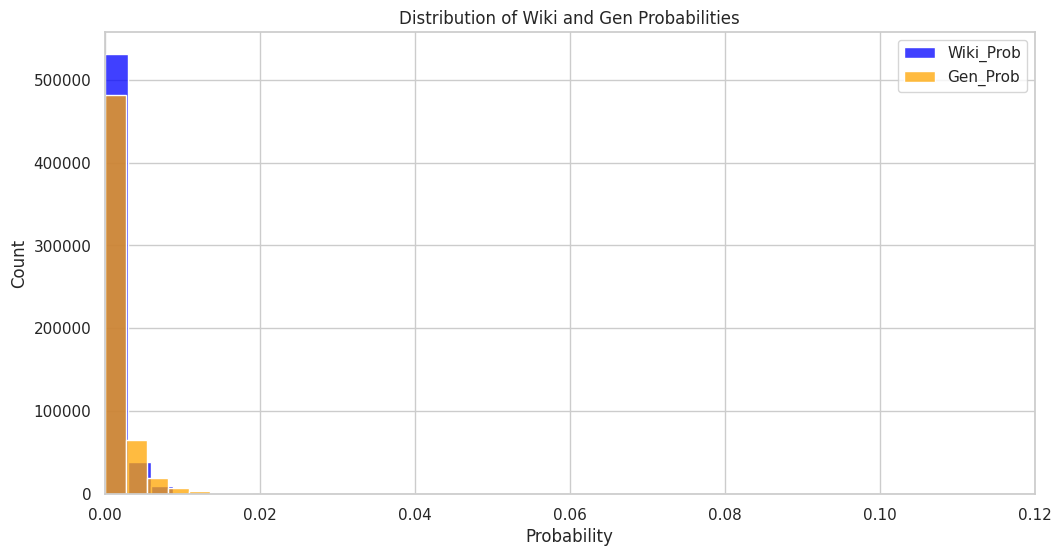

In [74]:
plt.figure(figsize=(12, 6))
sns.histplot(comparison_df['Wiki_Prob'], bins=40, color="blue", label="Wiki_Prob", kde=False)
sns.histplot(comparison_df['Gen_Prob'], bins=40, color="orange", label="Gen_Prob", kde=False)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Distribution of Wiki and Gen Probabilities')
plt.legend()
plt.xlim(0, 0.12)
plt.show()

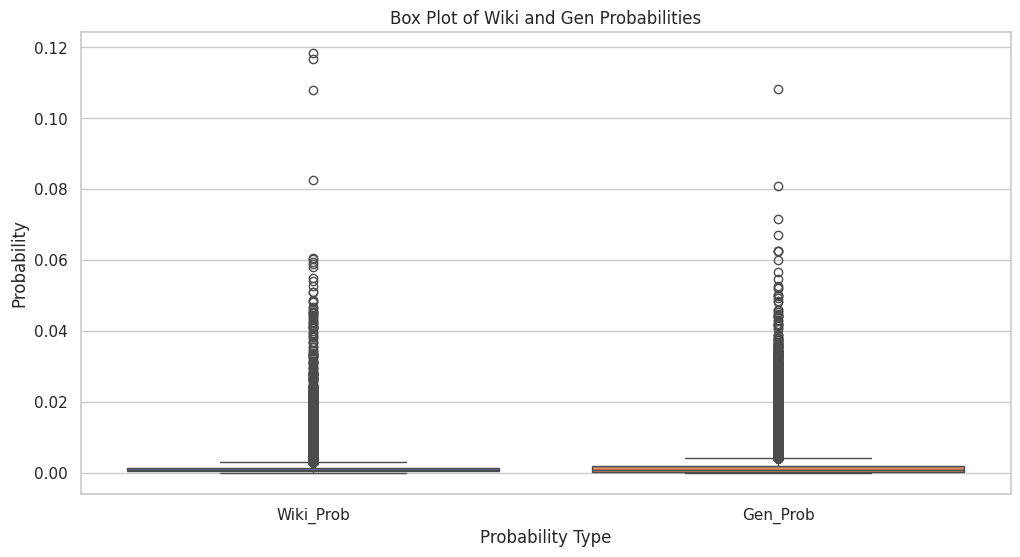

In [76]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=comparison_df[['Wiki_Prob', 'Gen_Prob']])
plt.xlabel('Probability Type')
plt.ylabel('Probability')
plt.xticks([0, 1], ['Wiki_Prob', 'Gen_Prob'])
plt.title('Box Plot of Wiki and Gen Probabilities')
plt.show()

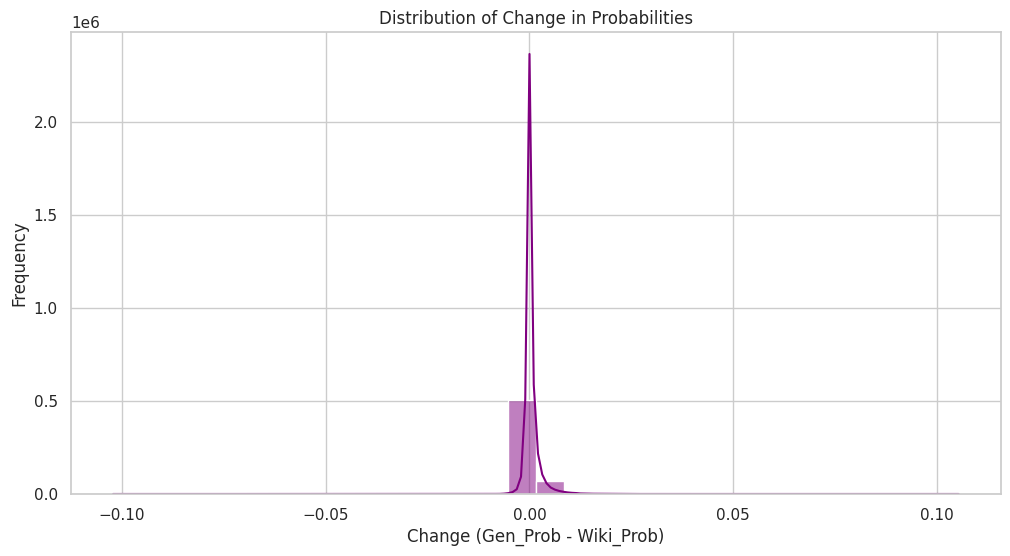

In [79]:
plt.figure(figsize=(12, 6))
sns.histplot(comparison_df['Change'], bins=30, color="purple", kde=True)
plt.xlabel('Change (Gen_Prob - Wiki_Prob)')
plt.ylabel('Frequency')
plt.title('Distribution of Change in Probabilities')
plt.show()

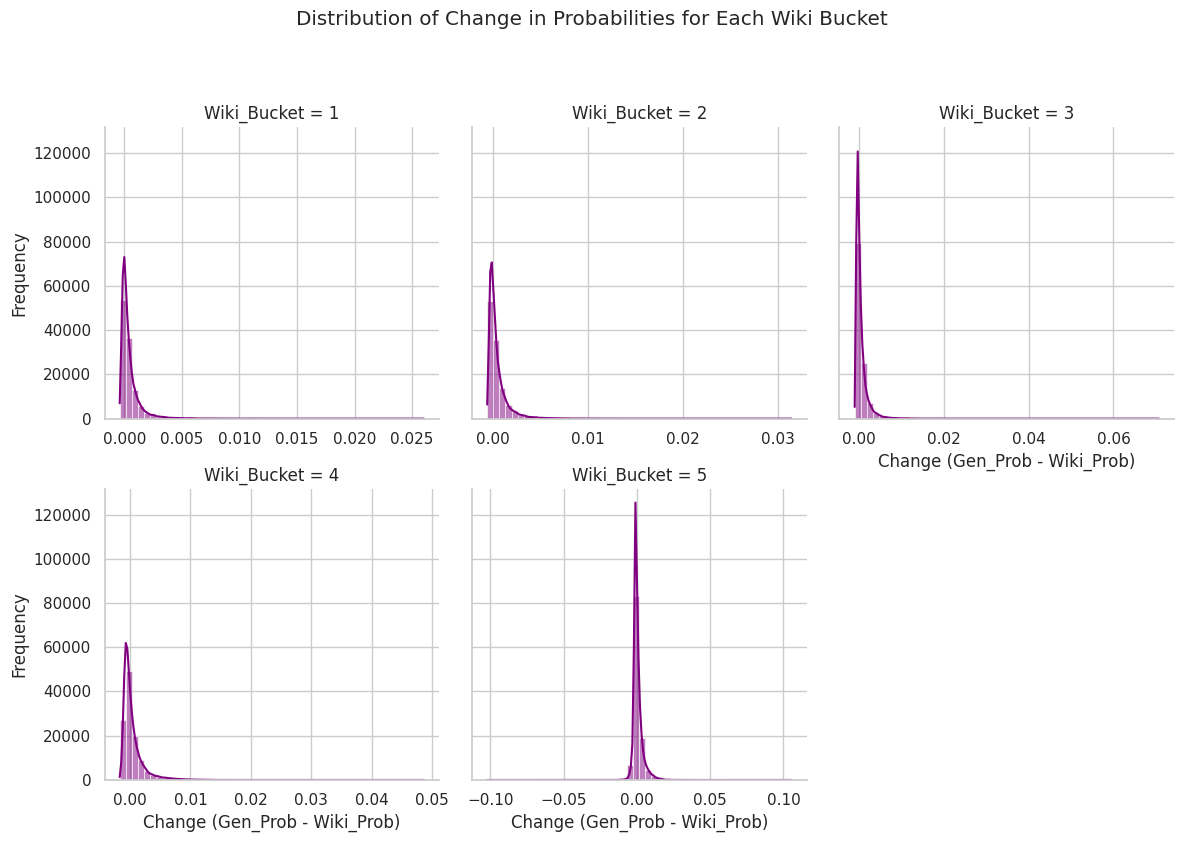

In [83]:
# Adjust x-axis limits individually and increase the number of bins
g = sns.FacetGrid(comparison_df, col="Wiki_Bucket", col_wrap=3, height=4, sharex=False, sharey=True)
g.map(sns.histplot, "Change", bins=50, color="purple", kde=True)

# Add overall labels and title
g.set_axis_labels("Change (Gen_Prob - Wiki_Prob)", "Frequency")
g.fig.suptitle("Distribution of Change in Probabilities for Each Wiki Bucket", y=1.05)
plt.tight_layout()
plt.show()


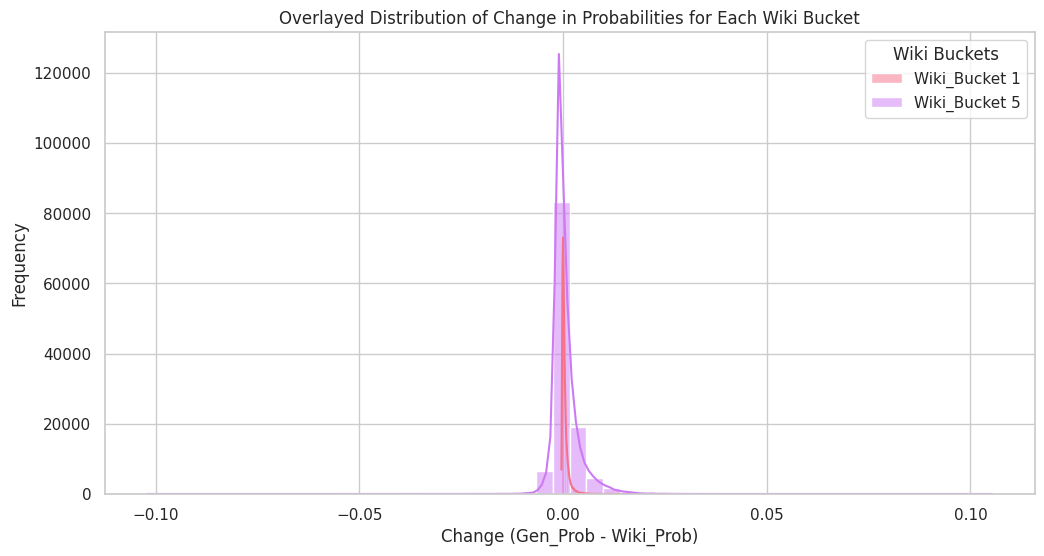

In [87]:
plt.figure(figsize=(12, 6))

# Define colors for each bucket
colors = sns.color_palette("husl", 5)  # Generate 5 distinct colors

# Plot the histogram for each Wiki_Bucket on the same plot
for i, bucket in enumerate(sorted(comparison_df['Wiki_Bucket'].unique())):
    if i == 0 or i == 4:
        sns.histplot(
            comparison_df[comparison_df['Wiki_Bucket'] == bucket]['Change'],
            bins=50,
            kde=True,
            color=colors[i],
            label=f'Wiki_Bucket {bucket}',
            alpha=0.5  # Transparency for better visibility when overlapping
        )

# Add labels and title
plt.xlabel('Change (Gen_Prob - Wiki_Prob)')
plt.ylabel('Frequency')
plt.title('Overlayed Distribution of Change in Probabilities for Each Wiki Bucket')
plt.legend(title='Wiki Buckets')
plt.show()


## More fine-grained buckets (doesn't really show much) and threshold

In [118]:
comparison_df2 = pd.merge(wiki_df, gen_df, on=['Feature1', 'Feature2'], how='inner')
comparison_df2 = comparison_df2[comparison_df2['Wiki_Prob'] > 0.005]
comparison_df2 = comparison_df2[comparison_df2['Gen_Prob'] != 0]

comparison_df2['Wiki_Bucket'] = pd.qcut(comparison_df2['Wiki_Prob'], 5, labels=False) + 1
comparison_df2['Gen_Bucket'] = pd.qcut(comparison_df2['Gen_Prob'], 5, labels=False) + 1

comparison_df2['Change'] = comparison_df2['Gen_Prob'] - comparison_df2['Wiki_Prob']
comparison_df2['Change_Direction'] = comparison_df2['Change'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change'))
comparison_df2

,Feature1,Feature2,Wiki_Prob,Gen_Prob,Wiki_Bucket,Gen_Bucket,Change,Change_Direction
0,abc,abc,0.007721,0.004287,4,2,-0.003433,Decrease
47,abc,appeared,0.006870,0.017149,3,5,0.010279,Increase
74,abc,award,0.007623,0.013934,4,5,0.006311,Increase
133,abc,cbs,0.005758,0.001072,2,1,-0.004686,Decrease
172,abc,comedy,0.005005,0.003215,1,1,-0.001790,Decrease
...,...,...,...,...,...,...,...,...
999898,zealand,television,0.008888,0.007333,5,3,-0.001555,Decrease
999934,zealand,two,0.005437,0.005041,1,2,-0.000396,Decrease
999982,zealand,work,0.005908,0.011457,2,5,0.005549,Increase
999994,zealand,year,0.007319,0.005041,4,2,-0.002278,Decrease


In [119]:
# 1. Calculate the stats of how many pairs move from each original bucket to each new bucket
comparison_df2.groupby(['Wiki_Bucket', 'Gen_Bucket']).size().unstack(fill_value=0)

Gen_Bucket,1,2,3,4,5
Wiki_Bucket,,,,,
1,1109,863,718,513,500
2,871,828,731,693,580
3,803,818,818,718,545
4,601,794,852,897,559
5,320,399,587,878,1519


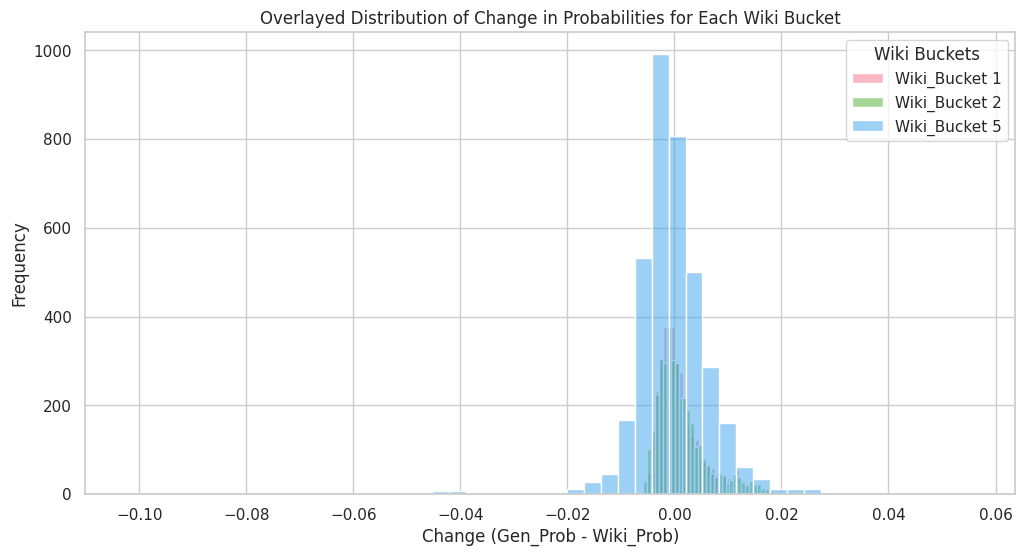

In [120]:
plt.figure(figsize=(12, 6))

# Define colors for each bucket
colors = sns.color_palette("husl", 3)  
ic = 0

# Plot the histogram for each Wiki_Bucket on the same plot
for i, bucket in enumerate(sorted(comparison_df2['Wiki_Bucket'].unique())):
    if i in [0,1,4]:
        color = ic
        sns.histplot(
            comparison_df2[comparison_df2['Wiki_Bucket'] == bucket]['Change'],
            bins=50,
            kde=False,
            color=colors[ic],
            label=f'Wiki_Bucket {bucket}',
            alpha=0.5  # Transparency for better visibility when overlapping
        )
        ic += 1

# Add labels and title
plt.xlabel('Change (Gen_Prob - Wiki_Prob)')
plt.ylabel('Frequency')
plt.title('Overlayed Distribution of Change in Probabilities for Each Wiki Bucket')
plt.legend(title='Wiki Buckets')
plt.show()


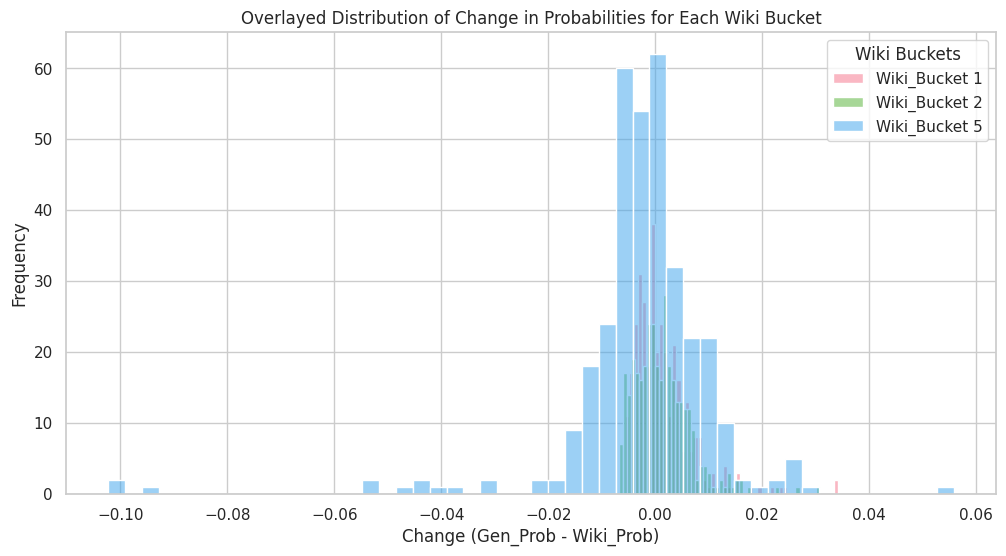

In [124]:
comparison_df2 = pd.merge(wiki_df, gen_df, on=['Feature1', 'Feature2'], how='inner')
comparison_df2 = comparison_df2[comparison_df2['Wiki_Prob'] > 0.01]
comparison_df2 = comparison_df2[comparison_df2['Gen_Prob'] > 0.005]

comparison_df2['Wiki_Bucket'] = pd.qcut(comparison_df2['Wiki_Prob'], 5, labels=False) + 1
comparison_df2['Gen_Bucket'] = pd.qcut(comparison_df2['Gen_Prob'], 5, labels=False) + 1

comparison_df2['Change'] = comparison_df2['Gen_Prob'] - comparison_df2['Wiki_Prob']
comparison_df2['Change_Direction'] = comparison_df2['Change'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change'))

plt.figure(figsize=(12, 6))

# Define colors for each bucket
colors = sns.color_palette("husl", 3)  
ic = 0

# Plot the histogram for each Wiki_Bucket on the same plot
for i, bucket in enumerate(sorted(comparison_df2['Wiki_Bucket'].unique())):
    if i in [0,1,4]:
        color = ic
        sns.histplot(
            comparison_df2[comparison_df2['Wiki_Bucket'] == bucket]['Change'],
            bins=50,
            kde=False,
            color=colors[ic],
            label=f'Wiki_Bucket {bucket}',
            alpha=0.5  # Transparency for better visibility when overlapping
        )
        ic += 1

# Add labels and title
plt.xlabel('Change (Gen_Prob - Wiki_Prob)')
plt.ylabel('Frequency')
plt.title('Overlayed Distribution of Change in Probabilities for Each Wiki Bucket')
plt.legend(title='Wiki Buckets')
plt.show()




In [126]:
comparison_df2 = comparison_df2.sort_values(by='Change', ascending=False)

In [127]:
comparison_df2

,Feature1,Feature2,Wiki_Prob,Gen_Prob,Wiki_Bucket,Gen_Bucket,Change,Change_Direction
395304,hall,fame,0.025037,0.080828,5,5,0.055791,Increase
55985,around,world,0.015153,0.067208,4,5,0.052055,Increase
590074,mtv,award,0.013663,0.062500,4,5,0.048837,Increase
553148,married,child,0.014929,0.050055,4,5,0.035125,Increase
765041,resides,angeles,0.010050,0.044280,1,5,0.034231,Increase
...,...,...,...,...,...,...,...,...
23186,affiliated,congress,0.058139,0.006024,5,1,-0.052115,Decrease
23811,affiliated,served,0.059415,0.006024,5,1,-0.053391,Decrease
514186,legislature,congress,0.118368,0.023121,5,5,-0.095247,Decrease
514567,legislature,mexican,0.116775,0.017341,5,4,-0.099434,Decrease
